## Dealing with missing data and lift rate effects

In [2]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp

In [3]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")


In [4]:
full_obs = df.copy().dropna()

#lift rates
int_lift_rates = full_obs['Intervention Average Lift Rate'].values.reshape(-1, 1)
base_lift_rates = full_obs['Baseline Average Lift Rate'].values.reshape(-1, 1)

#scores
int_scores = full_obs['Intervention Average Max Forward Bend'].values.reshape(-1, 1)
base_scores = full_obs['Baseline Average Max Forward Bend'].values.reshape(-1, 1)

#treatments
int_treatments = pd.get_dummies(full_obs['Haptic Group'])
tr_names = int_treatments.columns
treatments = int_treatments.values
tr_names

Index(['2 bends in 10 minutes', '2 bends in 5 minutes',
       '3 bends in 8 minutes'],
      dtype='object')

In [10]:
with pm.Model() as m:
    
    #register the data
    scores = pm.Data("scores", np.concatenate([base_scores, int_scores]))
    
    b_rates = pm.Data("baseline_rates", base_lift_rates)
    i_rates = pm.Data("intervention_rates", int_lift_rates)
    
    treats = pm.Data("treatments", treatments)
    no_treats = pm.Data("baseline", np.zeros(treatments.shape))
    
    #priors
    α = pm.Normal("lift_alpha", 0, sigma=10)
    lift_treatment = pm.Normal("lift_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))    
    ind_effects = pm.Normal("lift_fixed", 0, sigma=10, shape=(base_lift_rates.shape[0], 1))
      
    #obtain impact of treatment to lift scores    
    pred_lift_rates = α + b_rates + ind_effects + pm.math.dot(treats, lift_treatment)
    
    #estimate intervention lift rates
    residual_var = pm.HalfCauchy("lift_error", beta=5)
    est_int_rates = pm.Normal('lift_int', mu=pred_lift_rates, sigma = residual_var, observed = i_rates)
    
    #stack the data together
    lift_rates_stacked = pm.math.concatenate([b_rates, est_int_rates], axis=0)
    treatments_stacked = pm.math.concatenate([no_treats, treats], axis=0)
    
    #priors
    alpha = pm.Normal("score_alpha", 0, sigma=50)
    lift_beta = pm.Normal("score_lift", 0, sigma=10)
    treatment_betas = pm.Normal("score_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    fixed_effects = pm.Normal("score_fixed", 0, sigma=10, shape=(base_lift_rates.shape[0], 1))
    
    #stack as needed    
    fixed_effects_stacked = pm.math.concatenate([fixed_effects, fixed_effects], axis=0)
    
    #calculate score    
    s = alpha + (lift_beta * lift_rates_stacked) + fixed_effects_stacked + pm.math.dot(treatments_stacked, treatment_betas)
    
    #likelihood
    error_var = pm.HalfCauchy("score_error", beta=5)
    pm.Normal('likelihood', mu = s, sigma = error_var, observed = scores)
    
    #add ANOVA tests
    zero_to_one = pm.math.ge(treatment_betas[0], treatment_betas[1])
    zero_to_two = pm.math.ge(treatment_betas[0], treatment_betas[2])
    one_to_two = pm.math.ge(treatment_betas[1], treatment_betas[2])
    
    zero_best = zero_to_one * zero_to_two
    one_best = ~zero_to_one * one_to_two
    two_best = ~zero_to_two * ~one_to_two
    pm.Deterministic("treatment_0_best", zero_best)
    pm.Deterministic("treatment_1_best", one_best)
    pm.Deterministic("treatment_2_best", two_best)
    

/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [11]:
with m:
    trace = pm.sample(draws=1_000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lift_alpha, lift_treatment, lift_fixed, lift_error, score_alpha, score_lift, score_treatment, score_fixed, score_error]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 28 seconds.


In [12]:
results = az.summary(trace, hdi_prob=0.90)
rel_idx = [i for i in results.index if 'fixed' not in i]
results.loc[rel_idx, :]

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift_alpha,-6.650,5.265,-14.980,2.160,0.132,0.094,1590.0,1966.0,1.0
"lift_treatment[0, 0]",0.627,5.485,-8.594,9.451,0.133,0.094,1684.0,2415.0,1.0
"lift_treatment[1, 0]",-3.578,5.501,-12.587,5.401,0.136,0.096,1641.0,2114.0,1.0
"lift_treatment[2, 0]",-2.643,5.530,-11.482,6.393,0.132,0.094,1747.0,2327.0,1.0
score_alpha,57.233,2.041,53.976,60.664,0.066,0.047,951.0,1574.0,1.0
score_lift,0.267,0.018,0.237,0.297,0.001,0.000,1159.0,2052.0,1.0
"score_treatment[0, 0]",-6.267,0.818,-7.516,-4.846,0.014,0.010,3644.0,3132.0,1.0
"score_treatment[1, 0]",-5.197,0.768,-6.405,-3.900,0.012,0.009,3918.0,3455.0,1.0
"score_treatment[2, 0]",-3.543,0.822,-4.923,-2.217,0.014,0.010,3452.0,3067.0,1.0
lift_error,18.328,1.191,16.379,20.227,0.021,0.015,3197.0,3175.0,1.0


array([[<AxesSubplot:title={'center':'lift_alpha'}>,
        <AxesSubplot:title={'center':'lift_alpha'}>],
       [<AxesSubplot:title={'center':'lift_treatment'}>,
        <AxesSubplot:title={'center':'lift_treatment'}>],
       [<AxesSubplot:title={'center':'score_treatment'}>,
        <AxesSubplot:title={'center':'score_treatment'}>],
       [<AxesSubplot:title={'center':'lift_error'}>,
        <AxesSubplot:title={'center':'lift_error'}>],
       [<AxesSubplot:title={'center':'score_error'}>,
        <AxesSubplot:title={'center':'score_error'}>]], dtype=object)

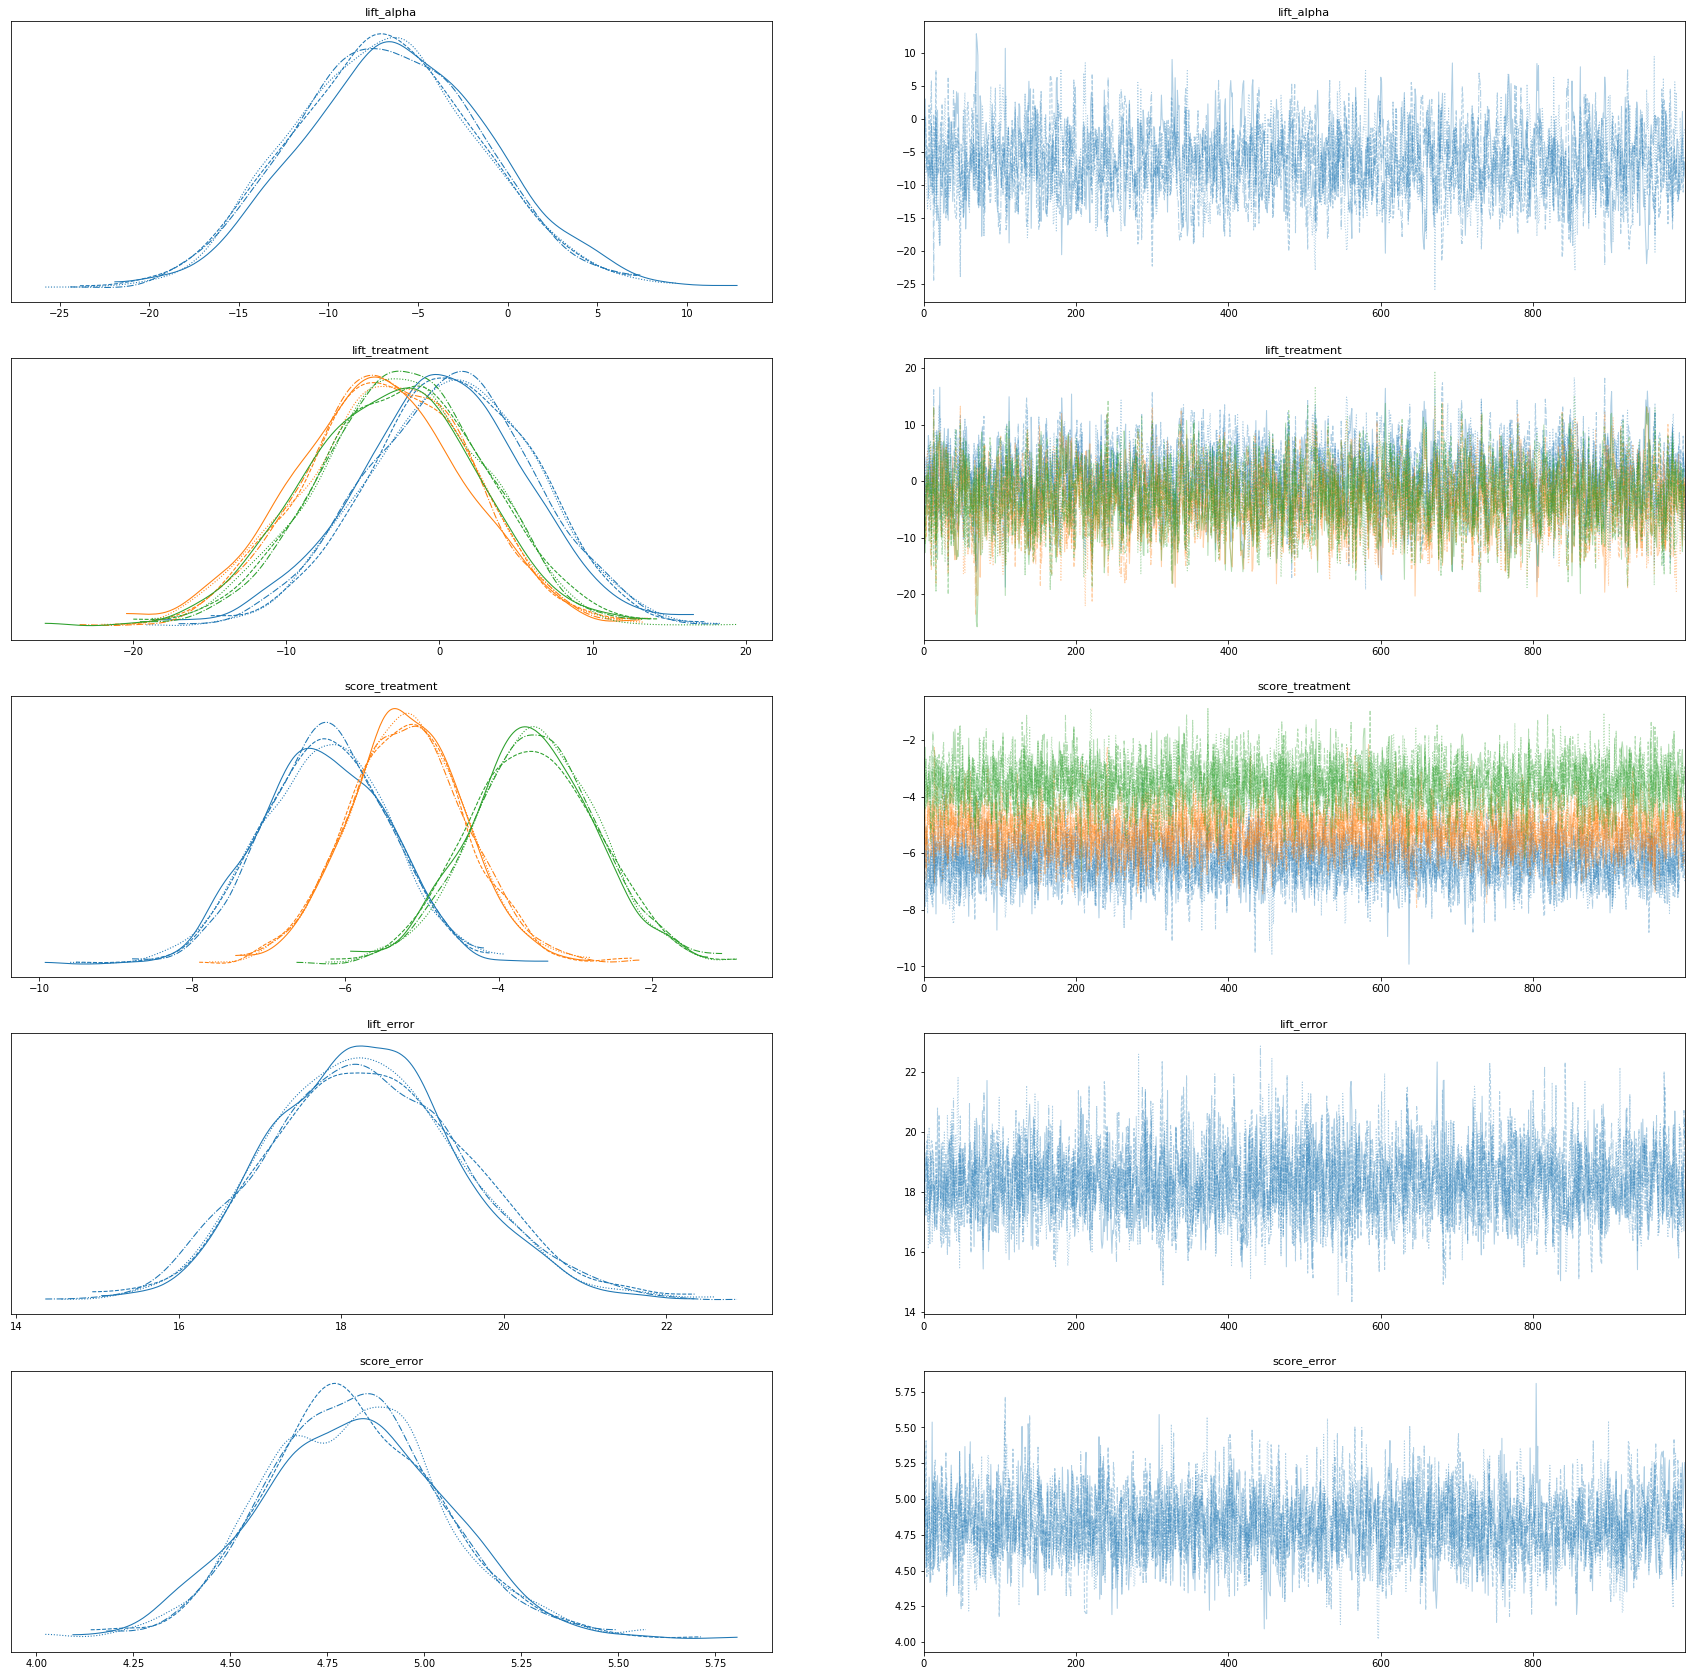

In [14]:
az.plot_trace(trace, figsize=(30,30), var_names=['lift_alpha', 'lift_treatment', 'score_treatment', 'lift_error', 'score_error'])